# Introduction
The goal of this project is to use twitter streaming API to collect text data, and perform Natural Language Processing (NLP) for sentiment analysis, and do a statistical analysis to see if a tweet in reply to different gender / affiliation, to see if the result shows statistically meaningful difference in terms of aggression / insult. The degree of "aggression/ insult" in a text are modeled based on https://arxiv.org/ftp/arxiv/papers/1604/1604.06648.pdf
https://arxiv.org/pdf/1604.06650.pdf
https://arxiv.org/pdf/1702.06877.pdf
and references therein.
As a pilot survey, we only include the 50 most significant figures on twitter according to wikipedia (whose gender is known). Accounts for groups / organizations are hand-picked and used as a comparison group. We only collect replies to these users. 

# Data
Uses of twitter APIata collecting and preprocessing step reference:
https://marcobonzanini.com/2015/03/09/mining-twitter-data-with-python-part-2/

## Training data
For training purposes, we started by collecting aggressive users on twitter and their tweets, provided by Despoina Chatzakou (Mean Birds): https://arxiv.org/pdf/1702.06877.pdf
However many of the tweets are unaccessible due to user suspension / authorization issues.
http://www.yichang-cs.com/yahoo/WWW16_Abusivedetection.pdf and dataset provided therein (e.g. Kaggle challenge) provides insulting comments with verification set.
The list of Google-banned bad words are obtained via https://www.freewebheaders.com/full-list-of-bad-words-banned-by-google/
We also apply GloVe and see how the result appears.
## Test data
Using Twitter streaming API, we collect tweets in reply to top 50 most followed users on twitter according to Wikipedia. The size of the dataset is 10k tweets to start with. 

# Processing tweets
We perform standard pre-processing of the tweeter text data, which involves:
tokenize, removing stop words, twitter-specific features (e.g. RT, @, ...).<br>
For GloVe, we modify the standard pre-processing such that we will still have rt, url, user etc as they are part of the embedding.

# Analysis
We test various sentiment analysis here. We use Vader as a starter, to assess the performance of a typical and easy-to-use sentiment analyzer on our training / verification data. We then test various widely used word embedding and algorithm to assess the performance of themover Vader. Finally we apply the algorithm to collected tweets, visualize and understand the result.

## Word embedding
### TfidfVectorizer
CountVectorizer (simple token count)-> TfidfTransformer. Probably more suitable for a large corpus with consistent context than individual tweets.
### GloVe
pre-trained unsupervised word clustering / vetorization of words provided by Stanford group.

## Classification
### Vader 
Pre-trained positive / negtaive sentiment analyzer. Tweets can be classified with the intensity of the sentiment. 
### RNN
RNN is a standard choice for sequence modeling (especially text data). We implemented RNN using Keras. We choose to use Gate Recurrent Unit (GRU) instead of Long-Short Term Memory Unit (LSTM) as GRU is simpler and tweets are short in length thus LSTM does not have advantage in this application.

In [294]:
# TIP: Install a pip package in the current Jupyter kernel
#import sys
#!{sys.executable} -m pip install numpy

In [295]:
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline

In [332]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences

from keras.models import Model
from keras.models import Sequential

from keras.layers import Input, Dense, Embedding, Conv1D, Conv2D, MaxPooling1D, MaxPool2D
from keras.layers import Reshape, Flatten, Dropout, Concatenate
from keras.layers import SpatialDropout1D, concatenate
from keras.layers import GRU, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D

from keras.callbacks import Callback
from keras.optimizers import Adam

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import load_model
from keras.utils.vis_utils import plot_model

In [296]:
try:
    import json
except ImportError:
    import simplejson as json

# Import the necessary methods from "twitter" library
# from twitter import Twitter, OAuth, TwitterHTTPError, TwitterStream

In [297]:
import pandas as pd
user_info = pd.read_csv('user_info.csv')
# hand-put gender to the user_info: F, M, G (group)

In [298]:
# hand-put gender to the user_info: Female, Male, Group (an organization or platform, or multiple people)
a = 'FMMFFFFMGMGFFFFFGMFMMFMMFGMFGMMGGMMGMMMGMMMFMMGFGM'
g = list(a)
g = pd.Series(g)
user_info = user_info.assign(gender= g.values)

In [299]:
print(user_info.head(6))

   Unnamed: 0               activity country  followers   user_id  \
0           0               Musician     USA        110  21447363   
1           1               Musician     CAN        107  27260086   
2           2  Former U.S. President     USA        103    813286   
3           3               Musician     BAR         89  79293791   
4           4               Musician     USA         86  17919972   
5           5               Musician     USA         79  14230524   

       user_name gender  
0      katyperry      F  
1   justinbieber      M  
2    BarackObama      M  
3        rihanna      F  
4  taylorswift13      F  
5       ladygaga      F  


In [300]:
# estimate the activity level of each users and include it to the user_info dataframe
# collecting tweets are again, done using Collect_tweetw_50mostpop_users.ipynb
past_filename = 'past_100_tweets.json'
with open(past_filename, encoding='utf-8') as f:
    pasts = json.load(f)

In [301]:
from datetime import datetime
import re
unformatted = "Thu Oct 20 02:40:55 +0000 2016"

def convert_time(twitter_time):
# Use re to get rid of the milliseconds.
    remove_ms = lambda x:re.sub("\+\d+\s","",x)
# Make the string into a datetime object.
    mk_dt = lambda x:datetime.strptime(remove_ms(x), "%a %b %d %H:%M:%S %Y")
# Format your datetime object.
#    my_form = lambda x:"{:%Y%m%d}".format(mk_dt(x))
    return mk_dt(twitter_time)

# Modeling activity of the user
We model the activity of each user at the recent time interval using Poisson distribution to test whether the user is particularly more / less active in the current time bin. We estimate l as the average number of tweets per bin (sample mean), and k to be the number of tweets in the bin where streaming data is collected. The probability of obtaining k tweets when average is l is then:

p(k) = exp(-l)l^k/(k!).

One should remember that each Poisson events are supposed to be independent. However, by modeling tweet events as Poisson distribution, we can estimate the activity of the user at the current time (week, if tweets are not frequent, otherwise smaller time window) and estimate the "activity" using activity function defined below. We use Poisson cumulative density function for this purpose.

In [302]:
from scipy.stats import poisson
 #use poisson cumulative distribution function to estimate the activity level of the user
# activity vs inactivity: when x is larger than the average, x is more active "than average". 
# but how much more? we try to quantify it using cumulative dist. func. 
# activity function is defined between -1 and 1: negative means the account is less active.
# positive means the account is more active.
def calc_act(x,l):
    # probability of getting x event or lower, given l
    lower = poisson.cdf(x,l)
    # probability of getting x event or higher, given l
    upper = 1-poisson.cdf(x,l)+poisson.pmf(x,l)
    if l > x:
        # chances of getting event higher than x when x is smaller than l (wth negative sign)
        # meaning "given l, it is this probable that the event is higher than x, but due to low activity, we got x"
        return (-1.+lower)
    else:
        # chances of getting event lower than x when x is higher than l
        # meaning "given l, it is this probable that the event is lower than x, but due to high activity, we got x"
        return (1.-upper)

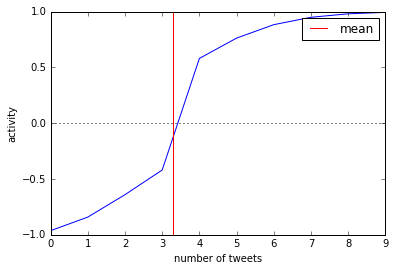

In [303]:
# Visualize how the activity function look like
l=3.3
n=10
x = [i for i in range(n)]
arr = [calc_act(i,l) for i in range(n)]
plt.plot(x,arr)
plt.axhline(y=0,color='black',linestyle=':')
plt.axvline(x=l,color='r',label = 'mean')
plt.ylabel("activity")
plt.xlabel("number of tweets")
plt.legend()
# getting average count means the activity is a bit "low" (by ~10%), because Poisson distribution is not symmetric.
# the plot is drown to the highest value of the given sample : when x = 7, the user is (more or less) 100% more active.

As desired, the activity -> 0 as the drawn number reaches the average. Activity reaches 1 as there are more tweets, and -1 as there is no tweet. With this definition, we estimate the activity of all users at the most recent interval and include it in the user_info dataframe. Depending on the user, the frequency of their tweets vary significantly: we have low-frequency user (whose 95th recent tweet is more than 4 weeks old) and high-frequency user (whose 95th recent tweet is less than 4 weeks old).

2015-07-10 15:10:28
User # 33 :Low-frequency Twitter user
activity of the most recent time bin: 0.543908437901


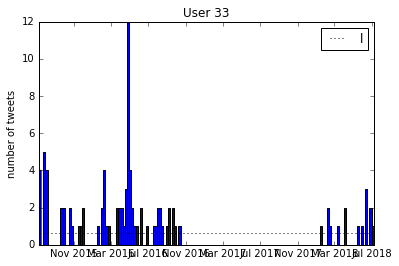

In [304]:
# with given user number u, visualize the tweets and estimate the current time-interval activity!
u = 33
test = [convert_time(pasts[u][i]['created_at']) for i in range(95)]
# for a few users, the 100 most recent data collection did not collect all the tweets (suspect internet connection issue),
# but it did collect data up to 95th most recent tweets for all the users which is close enough, so we proceed and use 95 tweets
test = test[::-1]
# the collection goes backward in time: we sort it in reverse order to put it back in time order.
print(test[0])

if (test[-1]-test[0]).days > 28:
    print("User #",u,":Low-frequency Twitter user")
    nbin = (test[-1]-test[0]).days
    # low-frequency users get larger bins: 4 days per bin or more
    histogram = plt.hist(test,bins=int(nbin/7))
else:
    print("User #",u,":High-frequency Twitter user")
    # high frequency users (who tweets more than 100 times in the past 4 weeks)
    histogram = plt.hist(test,bins=30)
# can I change this into bin_size=a day (roughly when the data is collected)?
l = np.average(histogram[0])
plt.ylabel("number of tweets")
plt.title("User %d"%(u))
plt.axhline(y=l,linestyle=':',color='black',label = 'l')
plt.legend()
print("activity of the most recent time bin:",calc_act(histogram[0][-1],l))

In [305]:
# For all users, estimate the activity
activity = []
for j in range(50):
    # some(5,33) user did not have 100 collected tweets: reduce the number down to 95...
    test = [convert_time(pasts[j][i]['created_at']) for i in range(95)]
    test = test[::-1]
    if (test[-1]-test[0]).days > 28:
        nbin = (test[-1]-test[0]).days
        histogram = plt.hist(test,bins=int(nbin/7))
        plt.close()
    else:
        # high frequency users (who tweets more than 100 times per 4 weeks)
        histogram = plt.hist(test,bins=30)
        plt.close()
# can I change this into bin_size=a day (roughly when the data is collected)?
    l = np.average(histogram[0])
    activity.append(calc_act(histogram[0][-1],l))

In [306]:
a = pd.Series(activity)
user_info = user_info.assign(actlevel= a.values)

In [307]:
# Categorizing activity into jobs in user_info
user_info.loc[user_info.activity.apply(lambda x: ('Musician') in x), 'job'] = 'artist'
user_info.loc[user_info.activity.apply(lambda x: ('Rapper') in x), 'job'] = 'artist'
user_info.loc[user_info.activity.apply(lambda x: ('Band') in x), 'job'] = 'artist'
user_info.loc[user_info.activity.apply(lambda x: ('Comedian') in x), 'job'] = 'artist'
user_info.loc[user_info.activity.apply(lambda x: ('Actor') in x), 'job'] = 'artist'
user_info.loc[user_info.activity.apply(lambda x: ('President') in x), 'job'] = 'politician'
user_info.loc[user_info.activity.apply(lambda x: ('Minister') in x), 'job'] = 'politician'
user_info.loc[user_info.activity.apply(lambda x: ('usiness' in x)), 'job'] = 'business'
user_info.loc[user_info.activity.apply(lambda x: ('ball') in x), 'job'] = 'sports'
user_info.loc[user_info.activity.apply(lambda x: ('platform' in x)), 'job'] = 'platform'
user_info.loc[user_info.activity.apply(lambda x: ('channel') in x), 'job'] = 'platform'
user_info.loc[user_info.activity.apply(lambda x: ('ews') in x), 'job'] = 'platform'
user_info.loc[user_info.activity.apply(lambda x: ('elevision') in x), 'job'] = 'TV'

## Defining the controversy level
model using the number of follwers, activity at the current epoch and number of replies: how controversial the account is, whether the insult rate increases depending on the controversy level. By modeling the activity using Poisson distribution rather than just number count of the tweets wrt the average, we can estimate how a user was active in a given period of time, 

In [356]:
# We have collected multiple tweets with varying numbers over a few days: see Collect_tweets_50mostpop_users.ipynb for details.
# in try clause we read these tweets collected: in total, 100k replies to the top users are collected.
tweets_filename = 'twitter_savereplies_nsamp10000.json'
tweets_filename2 = 'twitter_savereplies_nsamp20000.json'
tweets_filename3 = 'twitter_savereplies_nsamp30000.json'
tweets_filename4 = 'twitter_savereplies_nsamp40000.json'
# Since there are too many replies to one specific account, we decided to collect data
# with that account excluded... below are the data 
tweets_filename5 = 'twitter_savereplies_nsamp10000woDT.json'
tweets_filename6 = 'twitter_savereplies_nsamp40000woDT.json'

import os.path
# save to json file
tweet_count = 100
tweet_cnt = tweet_count
try:
    os.path.isfile(tweets_filename)
    os.path.isfile(tweets_filename2)
    print("files exists")
    with open(tweets_filename, 'r', encoding='utf-8') as f:
        tweets = json.load(f) # readline only the first tweet/line
    with open(tweets_filename2, 'r',encoding='utf-8') as f:
        tweets2 = json.load(f) # readline only the first tweet/line
    with open(tweets_filename3, 'r',encoding='utf-8') as f:
        tweets3 = json.load(f) # readline only the first tweet/line
    with open(tweets_filename4, 'r',encoding='utf-8') as f:
        tweets4 = json.load(f) # readline only the first tweet/line
    with open(tweets_filename5, 'r',encoding='utf-8') as f:
        tweets5 = json.load(f) # readline only the first tweet/line
    with open(tweets_filename6, 'r',encoding='utf-8') as f:
        tweets6 = json.load(f) # readline only the first tweet/line
    pass
# the execpt clause is a leftover from previous version of the code where data collection was combined with analysis part.
# it does not work for now, but I leave it here for a reference to what data we collected.
except:
    print("file does not exist, stream twitter for collecting tweets")
    tweets = []
    for tweet in iterator:
    # select only "replies" to top 50 followed users
        if str(tweet['in_reply_to_user_id']) in user_id:
            tweet_count -= 1
            tweets.append(tweet)
    # loads converts json format to python dictionary
    # dumps converts python dictionary to json format
    
    # The command below will do pretty printing for JSON data, try it out
    # print json.dumps(tweet, indent=4)
            if tweet_count <= 0:
                break     
    with open(tweets_filename, 'w') as outfile:
        json.dump(tweets,outfile,indent=4)
text = []
for i0 in range(tweet_cnt):
    text.append(tweets[i0]['text'])

files exists


# External dataset
We try using external data (corpus with sentiment labels) to train the network, from i) Kaggle challenge, ii) banned words by Google (not a official list, obtained from https://www.freewebheaders.com/full-list-of-bad-words-banned-by-google/), and iii) Mean Birds: https://arxiv.org/pdf/1702.06877.pdf and private communication with the first author (Despoina Chatzakou). In the end only i) is used for the final analysis.

In [447]:
banwords_file = './Google_BanWords/full-list-of-bad-words-text-file_2018_03_26.txt'
insult_corpus_file = './kaggle_insult/train.csv'
# In ideal world all strings would be unicode-escape, and we would not have any problem reading this as follows:
#insult_train = pd.read_csv(insult_corpus_file,encoding='unicode-escape')
# However, there are some strings that has double-backslash which complicate the process.
# i) we read strings as they are
# ii) then replace \\ by \
# iii) we cast it to unicode-escape
# iv) then we convert everything using unidecode
insult_train = pd.read_csv(insult_corpus_file)
banwords = pd.read_csv(banwords_file,sep='\r\n',engine='python',names = ['banword'])

In [448]:
#print(banwords)
banwords = banwords.replace('�','',regex=True)

In [449]:
banwords['Insult'] = 1

In [450]:
# the training set is a mixture of unicode characters with english. Let's clean it up...
from unidecode import unidecode as ud
import codecs
# ii) 
insult_train['Comment'] = [s.replace("\\\\", "\\") for s in insult_train['Comment']]
# iii)
insult_train['Comment'] = [s.replace("\\xc2\\xa0", " ") for s in insult_train['Comment']]
insult_train['Comment'] = [s.replace("\\xa0", " ") for s in insult_train['Comment']]
insult_train['Comment'] = [s.replace("\xa0", " ") for s in insult_train['Comment']]

insult_train['Comment'] = [codecs.decode(s,'unicode-escape') for s in insult_train['Comment']]
# iv)
insult_train['Comment'] = [ud(s) for s in insult_train['Comment']]
insult_train['Comment'] = [str(s) for s in insult_train['Comment']]

# there are almost no emoji in this dataset, so we don't need to worry about it. However, in real
# Twitter data, we do have a lot and thus we define clear_tweets functoin later.
print(insult_train['Comment'][987])
insult = insult_train.loc[insult_train['Insult']==1]
normal = insult_train.loc[insult_train['Insult']==0]

print(((insult['Comment'][0])))
print(((normal['Comment'][4])))
print(len(normal))

"I bet the songs on the upcoming CD were written for This twit. The message was she is a progressive. She knows where her  bread is buttered.

I have never even heard of her.

I bet if she had to write her own material. Ms Hoe would be a major disappointment to her idiotic fans.

What was her message with the exorcism? CBS management look like total knuckleheads. No wonder their ratings suck.

Bring back garage bands. They play instruments, write their own material & perform to their fans.

Most of the music truly sucks today. Record executives don't even try to find pure raw talent.. It seems they try to clone their stars. Visual imagery for shock value over solid Rock-n-Roll.

"
"You fuck your dad."
"Cac ban xuong duong bieu tinh 2011 co on hoa khong ? 
Cac ngu dan ngoi cui dau chiu nhuc co on hoa khong ?
Cac nong dan giu dat o Van Giang, Can Tho co on hoa khong ?
.................
Rot cuoc duoc gi  thi chung ta da biet !
Ai cung yeu chuong hoa binh, nhung doi khi hoa binh chi that s

In [361]:
training_file = './dataset/data'
training_data = pd.read_csv(training_file,delim_whitespace=True,names=['user','category','tweet_id'])
ID = []
for i in range(len(training_data)):
    ID.append(training_data['tweet_id'][i].split(","))
#print(training_data)
# category is divided into four: aggressor, bully, normal and spammer
# each up to (43, 101, 883, 1303) id indices and 5-10 tweets.
# It can take long time to collect these tweets, so I save them as json files with their indices provided in the dataset.

In [362]:
# saved aggressive / bullying tweets for later runs
agg_filename = 'agg_tweets.json'
bull_filename= 'bull_tweets.json'
norm_filename = 'norm_tweets.json' 

In [363]:
#t.statuses.oembed(_id=672282716436467714)
try:
    os.path.isfile(agg_filename)
    with open(agg_filename, 'r',encoding='utf-8') as f:
        agg_tweets = json.load(f) # readline only the first tweet/line
    print("agg_file exist: read and pass")
    pass
except:
    print("agg_file does not exist: collect tweets from twitter database")
    agg_tweets = []
    agg_index = []
    ID_idx = [len(x) for x in ID]
    for i in range(0,43):
        for j in range(ID_idx[i]):
            try:
                agg_tweets.append(t.statuses.show(_id=ID[i][j]))
                agg_index.append(i)
                print(i,j)
            except:
                pass
    with open(agg_filename, 'w') as outfile:
        json.dump(agg_tweets,outfile,indent=4)
    with open('agg_tweets_idx.txt','w') as outfile:
        json.dump(agg_index,outfile)
    print("aggressive tweets collected and saved")

agg_file exist: read and pass


In [364]:
#t.statuses.oembed(_id=672282716436467714)
try:
    os.path.isfile(bull_filename)
    with open(bull_filename, 'r',encoding='utf-8') as f:
        bull_tweets = json.load(f) # readline only the first tweet/line
    print("bull_file exist: read and pass")
    pass
except:
    print("bull_file does not exist: collect tweets from twitter database")
    ID_idx = [len(x) for x in ID]
    bull_tweets = []
    bull_index = []
    for i in range(43,101):
        for j in range(ID_idx[i]):
            try:
                bull_tweets.append(t.statuses.show(_id=ID[i][j]))
                bull_index.append(i)
                print(i,j)
            except:
                pass
    with open(bull_filename, 'w') as outfile:
        json.dump(bull_tweets,outfile,indent=4)
    with open('bull_tweets_idx.txt','w') as outfile:
        json.dump(bull_index,outfile)
    print("bully tweets collected and saved")

bull_file exist: read and pass


In [365]:
#t.statuses.oembed(_id=672282716436467714)
try:
    os.path.isfile(norm_filename)
    with open(norm_filename, 'r',encoding='utf-8') as f:
        norm_tweets = json.load(f) # readline only the first tweet/line
    print("norm_file exist: read and pass")
    pass
except:
    print("norm_file does not exist: collect tweets from twitter database")
    norm_tweets = []
    norm_index = []
    ID_idx = [len(x) for x in ID]
    for i in range(101,883):
        for j in range(ID_idx[i]):
            try:
                norm_tweets.append(t.statuses.show(_id=ID[i][j]))
                norm_index.append(i)
                print(i,j)
            except:
                pass
    with open(norm_filename, 'w') as outfile:
        json.dump(norm_tweets,outfile,indent=4)
    with open('norm_tweets_idx.txt','w') as outfile:
        json.dump(norm_index,outfile)
    print("normal tweets collected and saved")

norm_file exist: read and pass


In [366]:
norm_tweets_text = [norm_tweets[i]['text'] for i in range(len(norm_tweets))]
# tweets from aggressive + bullying users currently available are about 100... :x

In [367]:
#print(norm_tweets_text)

In [368]:
#>>> ad.encode('utf-16','surrogatepass').decode('utf-16')
#'😍'
#>>> import unicodedata
#>>> unicodedata.name(ad.encode('utf-16','surrogatepass').decode('utf-16'))
#'SMILING FACE WITH HEART-SHAPED EYES'
#>>> ad
#'\ud83d\ude0d'

#import unicodedata
#print(unicodedata.name("\ud83d\ude0d".encode('utf-16','surrogatepass').decode('utf-16')))

In [369]:
# tweeter seems to have worked well and suspended most of the accounts the authors classified as aggressors / bullies,
# which is unfortunate for our purpose but we will proceed with the currently available data...?

# Processing the text
Using nltk, we pre-process the text here. Tokenized words will be feed into multiple classifier to determine the degree of aggression in the text. We compare their performances and decide which algorithm to use.

In [370]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer

In [371]:
 emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""
 
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]
    
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)

In [372]:
def emoji_finder(string):
# find utf-16 surrogate emojis (as twitter API provides) and convert it to its description using unicodedata
#a = "Baby you're perfect! \ud83d\ude0d\ud83d\ude0d"
#a = re.sub(r'\\u(.{10})',(unicodedata.name("\\u\1".encode('utf-16','surrogatepass').decode('utf-16'))),a)
    # suggogate pair
    string = string.encode('utf-8')
    #m = re.findall(r'(\ud838[\udc50-\udfff])|([\ud839-\ud83d][\udc00-\udfff])|(\ud83e[\udc00-\udfbf])|([\udc50-\udfff]\ud838)|([\udc00-\udfff][\ud839-\ud83d])|([\udc00-\udfbf]\ud83e)',string)
    m = re.findall(b'(\xf0[\x00-\xff][\x00-\xff][\x00-\xff])',string)
    em_uni = []
    em_desc = []
    for i in range(len(m)):
        if m[i] is not '':
                em_uni.append(m[i])
                try:
                    em_desc.append(' '+unicodedata.name(m[i].decode('utf-8'))+' ')
                except:
                    em_desc.append(' ')
    return (em_uni,em_desc)

In [373]:
import unicodedata
# test whether emoji_finder function works
#txt = "Baby you're perfect! \ud83d\ude0d\ud83d\ude0d"
#txt = "Omg!I'm so proud of them! jamesxreid hellobangsie \ud83d\ude18\ud83d\udc67\ud83d\ude4b\n#OTWOLFromADistance \n#PushAwardsJaDines"
#txt = "Please Shawn I need to get a dm from you \ud83d\udc99\ud83d\ude4c\ud83c\udffc\ud83d\ude4c\ud83c\udffc\nI love you so much angel \ud83d\udc7c\ud83c\udffc\ud83d\udc98"
txt = "Baby you're perfect! 😍😍"
#a = re.sub(r'\\u(.{10})',(unicodedata.name("\\u\1".encode('utf-16','surrogatepass').decode('utf-16'))),a)
m = re.findall(r'(\ud838[\udc50-\udfff])|([\ud839-\ud83d][\udc00-\udfff])|(\ud83e[\udc00-\udfbf])|([\udc50-\udfff]\ud838)|([\udc00-\udfff][\ud839-\ud83d])|([\udc00-\udfbf]\ud83e)',txt)
a = []
for i in range(len(m)):
    for j in range(6):
        if m[i][j] is not '':
            a.append(unicodedata.name(m[i][j].encode('utf-16','surrogatepass').decode('utf-16')))
print(a)
uni, desc = emoji_finder(txt) 
print(uni)
print(desc)
txt = txt.encode('utf-8')
for i in range(len(uni)):
    txt = re.sub(uni[i], desc[i].encode('utf-8'), txt)
txt = txt.decode('utf-8')
print(txt)

[]
[b'\xf0\x9f\x98\x8d', b'\xf0\x9f\x98\x8d']
[' SMILING FACE WITH HEART-SHAPED EYES ', ' SMILING FACE WITH HEART-SHAPED EYES ']
Baby you're perfect!  SMILING FACE WITH HEART-SHAPED EYES  SMILING FACE WITH HEART-SHAPED EYES 


In [374]:
import string
 
from nltk.corpus import stopwords 
stopwords_english = stopwords.words('english')
 
from nltk.stem import PorterStemmer, WordNetLemmatizer
stemmer = PorterStemmer()
wnl = WordNetLemmatizer()

from nltk.tokenize import TweetTokenizer
 
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])
 
# all emoticons (happy + sad)
emoticons = emoticons_happy.union(emoticons_sad)
jav_emj = r'(\ud838[\udc50-\udfff])|([\ud839-\ud83d][\udc00-\udfff])|(\ud83e[\udc00-\udfbf])|([\udc50-\udfff]\ud838)|([\udc00-\udfff][\ud839-\ud83d])|([\udc00-\udfbf]\ud83e)'
def clean_tweets(tweet):
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # replace utf-16 emoji to description of the emoji
    uni,desc = emoji_finder(tweet)
    tweet = tweet.encode('utf-8')
    for i in range(len(uni)):
        tweet = re.sub(uni[i],desc[i].encode('utf-8'),tweet)
    tweet = tweet.decode('utf-8')
    # remove abbreviation marks?
    tweet = re.sub(r'/[.]{2,}/g','',tweet)
    # remove mention @ 
    tweet = re.sub(r"@(\w+)", '', tweet)

    return tweet

def clean_tweets_glove(tweet):
    # remove stock market tickers like $GE
    tweet = re.sub(r'\$\w*', '', tweet)
    # remove old style retweet text "RT"
    # glove keeps rt
#    tweet = re.sub(r'^RT[\s]+', '', tweet)
    # remove hyperlinks
    # glove keept hyperlinks as <URL>
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '<url> ', tweet)
    # remove hashtags
    # only removing the hash # sign from the word
    tweet = re.sub(r'#', '', tweet)
    # replace utf-16 emoji to description of the emoji
    uni,desc = emoji_finder(tweet)
    tweet = tweet.encode('utf-8')
    for i in range(len(uni)):
        tweet = re.sub(uni[i],desc[i].encode('utf-8'),tweet)
    tweet = tweet.decode('utf-8')
    # remove abbreviation marks?
    tweet = re.sub(r'/[.]{2,}/g','',tweet)
    # remove mention @ 
    # glove keeps mention as <USER>
    tweet = re.sub(r"@(\w+)", '', tweet)

    return tweet

In [375]:
# feature extractor function
def bag_of_words(tweet):
    tweets = clean_tweets(tweet)
    # tokenize tweets
    # what does reduce_len do?
    tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
    tweet_tokens = tokenizer.tokenize(tweets)
 
    tweets_clean = []    
    for word in tweet_tokens:
        if (word not in stopwords_english and # remove stopwords
              word not in emoticons and # remove emoticons
                word not in string.punctuation): # remove punctuation
            #tweets_clean.append(word)
            #stem_word = stemmer.stem(word) 
            # stemming word : tend to remove 'e' from ending of some words. replaced by WordNetLemmatizer
            wnl_word = wnl.lemmatize(word)
            #tweets_clean.append(stem_word)
            tweets_clean.append(wnl_word)

    words_dictionary = dict([word, True] for word in tweets_clean)  

    return words_dictionary

In [376]:
def tokenize(tweet):
    tweet = re.sub(r'http\S+', '', tweet)
    tweet = re.sub(r"#(\w+)", '', tweet)
    tweet = re.sub(r"@(\w+)", '', tweet)
    tweet = re.sub(r'[^\w\s]', '', tweet)
    tweet = tweet.strip().lower()
    tokens = word_tokenize(tweet)
    return tokens

In [377]:
def preprocess(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

In [378]:
print(preprocess(text[50]))
print(clean_tweets(text[50]))

['let', 'a', 'mexican', 'replace', 'you', 'not', 'italian', 'as', 'it', 'was', 'supposed', 'as', 'next', 'potus', 'they', 'are', 'too', 'violent', 'i']
 Let a Mexican replace you, not Italian, as it was supposed, as next POTUS. They are too violent. I… 


In [446]:
# let's import verification data from the Kaggle challenge
ver_file = './kaggle_insult/impermium_verification_labels.csv'
ver_data = pd.read_csv(ver_file,encoding='unicode-escape')
print(ver_data.head(5))

ver_data['Comment'] = [s.replace("\\\\", "\\") for s in ver_data['Comment']]
# iii)
# remove non break space
ver_data['Comment'] = [s.replace("\\xc2\\xa0", " ") for s in ver_data['Comment']]
#remove space
ver_data['Comment'] = [s.replace("\\xa0", " ") for s in ver_data['Comment']]
ver_data['Comment'] = [s.replace("\xa0", " ") for s in ver_data['Comment']]
ver_data['Comment'] = [codecs.decode(s,'unicode-escape') for s in ver_data['Comment']]
# iv)
ver_data['Comment'] = [ud(s) for s in ver_data['Comment']]
ver_data['Comment'] = [str(s) for s in ver_data['Comment']]
print(ver_data['Comment'][732])

insult_ver = ver_data.loc[ver_data['Insult']==1]
normal_ver = ver_data.loc[ver_data['Insult']==0]

insult_ver_set = []
for tweet in insult_ver['Comment']:
    insult_ver_set.append((bag_of_words(tweet), 'ins'))
    
norm_ver_set = []
for tweet in normal_ver['Comment']:
    norm_ver_set.append((bag_of_words(tweet), 'norm'))

train_x = insult_train['Comment'][:].append(ver_data['Comment'][:1000],ignore_index=True)
train_x = train_x.append(banwords['banword'],ignore_index=True)
train_y = insult_train['Insult'][:].append(ver_data['Insult'][:1000],ignore_index=True)
train_y = train_y.append(banwords['Insult'],ignore_index=True)

norm_tweets_ = pd.DataFrame(norm_tweets_text,columns=['text'])
norm_tweets_['insult'] = 0

train_x = train_x.append(norm_tweets_['text'],ignore_index=True)
train_y = train_y.append(norm_tweets_['insult'],ignore_index=True)

ver_x = ver_data['Comment'][1000:]
ver_y = ver_data['Insult'][1000:]

   id  Insult             Date  \
0   1       0  20120603163526Z   
1   2       1  20120531215447Z   
2   3       1  20120823164228Z   
3   4       1  20120826010752Z   
4   5       1  20120602223825Z   

                                             Comment        Usage  
0                 "like this if you are a tribe fan"  PrivateTest  
1              "you're idiot......................."  PrivateTest  
2  "I am a woman Babs, and the only "war on women...  PrivateTest  
3  "WOW & YOU BENEFITTED SO MANY WINS THIS YEAR F...  PrivateTest  
4  "haha green me red you now loser whos winning ...  PrivateTest  
"People sell their grandmother for twenty bucks and you think they care about your feelings being hurt by posting your mugshot on the internet?  Really, think about it.  They sell medication to dying sick that's made up out of chalk and dirt and they don't lose sleep over it.  Suddenly we expect bunch of dotc um a55 holes to do what's right.  Get over it.  "


In [380]:
def get_coefs(word, *arr):
    try:
        return word, np.asarray(arr, dtype='float32')
    except:
        return None, None
    
embeddings_index = dict(get_coefs(*o.strip().split()) for o in open('../GloVe/glove.twitter.27B.200d.txt'))

embed_size=200
for k in list(embeddings_index.keys()):
    v = embeddings_index[k]
    try:
        if v.shape != (embed_size, ):
            embeddings_index.pop(k)
    except:
        pass
            
#embeddings_index.pop(None)  

In [381]:
values = list(embeddings_index.values())
all_embs = np.stack(values)

emb_mean, emb_std = all_embs.mean(), all_embs.std()

In [382]:
# we try uni-/bigram (word / character) approach here following 
# https://ahmedbesbes.com/overview-and-benchmark-of-traditional-and-deep-learning-models-in-text-classification.html
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score
from sklearn.externals import joblib

import scipy
from scipy.sparse import hstack

In [383]:
# Try TFIDF 
vectorizer_word = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='word', 
                             stop_words='english', 
                             ngram_range=(1, 2))

vectorizer_word.fit(train_x)

tfidf_matrix_word_train = vectorizer_word.transform(train_x)
tfidf_matrix_word_test = vectorizer_word.transform(ver_x)

In [384]:
lr_word = LogisticRegression(solver='sag', verbose=2)
lr_word.fit(tfidf_matrix_word_train, train_y)

convergence after 19 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='sag', tol=0.0001,
          verbose=2, warm_start=False)

In [385]:
joblib.dump(lr_word, 'lr_word_ngram.pkl')

y_pred_word = lr_word.predict(tfidf_matrix_word_test)
pd.DataFrame(y_pred_word, columns=['y_pred']).to_csv('lr_word_ngram.csv', index=False)

In [386]:
y_pred_word = pd.read_csv('lr_word_ngram.csv')
print(accuracy_score(ver_y, y_pred_word))

0.681781376518


In [387]:
vectorizer_char = TfidfVectorizer(max_features=40000,
                             min_df=5, 
                             max_df=0.5, 
                             analyzer='char', 
                             ngram_range=(1, 4))

vectorizer_char.fit(train_x);

tfidf_matrix_char_train = vectorizer_char.transform(train_x)
tfidf_matrix_char_test = vectorizer_char.transform(ver_x)

lr_char = LogisticRegression(solver='sag', verbose=2)
lr_char.fit(tfidf_matrix_char_train, train_y)

y_pred_char = lr_char.predict(tfidf_matrix_char_test)
joblib.dump(lr_char, 'lr_char_ngram.pkl')

pd.DataFrame(y_pred_char, columns=['y_pred']).to_csv('lr_char_ngram.csv', index=False)

convergence after 17 epochs took 0 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [388]:
y_pred_char = pd.read_csv('lr_char_ngram.csv')
print(accuracy_score(ver_y, y_pred_char))

0.71012145749


In [451]:
custom_tweet = "RT @Twitter @chapagain Hello There! Have a great day. :) #good #morning http://chapagain.com.np"
#print (bag_of_words('565 I vote for #RajeevKhandelwal The basis of optimism is sheer terror.\ud83d\udc99\ud83d\udc99\ud83d\udc99\ud83d\udc99\u2764\u2764\u2764 @RajBaddhan   @SabrasRadio   #TVPersonality2015  @BizAsia'))
print(bag_of_words(('"'+norm_tweets_text[-56]+'"')))
print(norm_tweets_text[-56])
'''
Output:
 
{'great': True, 'good': True, 'morning': True, 'hello': True, 'day': True}
'''
# insult tweets feature set
insult_tweets_set = []
for tweet in insult['Comment']:
    insult_tweets_set.append((bag_of_words(tweet), 'ins'))    
for words in banwords['banword']:
    insult_tweets_set.append((bag_of_words(words),'ins'))
# normal tweets feature set
normal_tweets_set = []
for tweet in normal['Comment']:
    normal_tweets_set.append((bag_of_words(tweet), 'norm'))
for tweet in norm_tweets_text:
    normal_tweets_set.append((bag_of_words(tweet), 'norm'))
print(len(insult_tweets_set), len(normal_tweets_set))

{'sheer': True, 'terror': True, 'optimism': True, '❤': True, '565': True, 'vote': True, 'tvpersonality': True, 'blue': True, '2015': True, 'rajeevkhandelwal': True, 'basis': True, 'heart': True}
565 I vote for #RajeevKhandelwal The basis of optimism is sheer terror.💙💙💙💙❤❤❤ @RajBaddhan   @SabrasRadio   #TVPersonality2015  @BizAsia
2298 5793


In [390]:
print(normal_tweets_set[-56])

({'sheer': True, 'terror': True, 'optimism': True, '❤': True, '565': True, 'vote': True, 'tvpersonality': True, 'blue': True, '2015': True, 'rajeevkhandelwal': True, 'basis': True, 'heart': True}, 'norm')


In [419]:
# try n-fold (minibatch) later
from random import shuffle, seed
seed(10)
#shuffle(insult_tweets_set)
#shuffle(normal_tweets_set)
 
#test_set = insult_tweets_set[:1000] + normal_tweets_set[:1000]
#train_set = insult_tweets_set[1000:] + normal_tweets_set[1000:]
train_set = insult_tweets_set + normal_tweets_set + insult_ver_set[:500] + norm_ver_set[:500]
#train_set = normal_tweetw_set
test_set = insult_ver_set[500:] + norm_ver_set[500:]
print(len(test_set),  len(train_set)) # Output: (2000, 8000)
print(len(insult_tweets_set), len(normal_tweets_set))
print(len(insult_ver_set),len(norm_ver_set))

1235 9091
2298 5793
1077 1158


In [392]:
print(train_set)

[({'dad': True, 'fuck': True}, 'ins'), ({'rest': True, 'shut': True, 'friend': True, 'burned': True, 'fuck': True, 'faggot': True, 'stake': True}, 'ins'), ({'either': True, 'stupid': True, '...': True, 'fake': True, 'extremely': True, 'maybe': True}, 'ins'), ({'understands': True, 'health': True, 'neither': True, 'idiot': True, 'taxation': True, "women's": True}, 'ins'), ({'negro': True, 'sound': True, 'u': True, 'retarded': True, 'damn': True, 'lol': True, 'reason': True}, 'ins'), ({'...': True, 'pieceofshit': True, 'racist': True, 'name': True, 'screen': True}, 'ins'), ({'...': True, 'dickhead': True}, 'ins'), ({'head': True, 'post': True, 'retard': True, 'go': True}, 'ins'), ({'sickening': True, 'hypocrisy': True, 'allinit': True, 'loser': True, 'ignorant': True, '123': True}, 'ins'), ({'believe': True, 'fool': True, 'stupid': True, 'hiding': True, 'useful': True, 'look': True, 'idiot': True, 'site': True, 'people': True, 'going': True, 'like': True, 'protect': True, 'idea': True, "

# Word embedding: efficient vectorization of words
By vectorizing words, we can reduce the sparcity and dimensionality of the feature space. 
The representation is normally ~ 100-1000 dimension. The basic concept behind it is that words used in
similar context have similar meanings.
## Embedding layer
Using NN for language modeling or document classification. 
## Word2vec
probably not easy with twitter texts as individual tweets are very short and thus predicting word from the surrounding (both for CBoW and Cont. skip-gram) would be hard? : not much freedom in choosing the sliding window size...
## GloVe
Word2Vec with additional information about the context from the whole corpus. Provides "Unsupervised" clustering of vocab, purely based on a large corpus of data. We use pre-trained GloVe vocabulary vector library collected from Twitter data from https://github.com/stanfordnlp/GloVe (2B tweets, 27B tokens, 1.2M vocab, uncased, 25d, 50d, 100d, & 200d vectors, 1.42 GB).

Reference : https://machinelearningmastery.com/what-are-word-embeddings/

### Vader sentiment analysis (pos,neg)- how useful is it? Let's see!

In [393]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
#AttributeError: 'SentimentIntensityAnalyzer' object has no attribute 'polarity_score'

In [394]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
analyser = SentimentIntensityAnalyzer()
cnt = 0
insult_cmt = insult.reset_index()
for i in range(len(insult_cmt)):
    snt = analyser.polarity_scores(insult_cmt['Comment'][i])
    if snt.get('neg') > snt.get('pos'):
        cnt += 1
#        print(i,snt)
print(cnt/len(insult))
print(insult_cmt['Comment'][11])
# only about 11% of the ban words are categorized as having negative connotation according to Vader.
# Lord Vader is in the end not as grandiose as the name promises :o
# only 9% of the insult comments from Kaggle competition are negative if neg > .5 is counted.
# (when negative > positive: 63% : this is similar to our NBC result).

0.6444232602478551
"Is that it??  your sum total to any conversation is first abuse and then calling them a troll..   You are a typical socialist idiot.  Keep up your non existent class warfare, it is as pointless as you."


In [395]:
from nltk import classify
import nltk.classify.util, nltk.metrics
from nltk.classify import NaiveBayesClassifier, MaxentClassifier, SklearnClassifier, DecisionTreeClassifier
from sklearn import cross_validation
from sklearn.svm import LinearSVC, SVC
import itertools
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures

print("!!!NaiveBayesClassifier!!!")
nbclassifier = NaiveBayesClassifier.train(train_set)
accuracy = classify.accuracy(nbclassifier, test_set)
print(accuracy) # Output: 0.765
print (nbclassifier.show_most_informative_features(10)) 

print("!!!MaxEntropyClassifier!!!")
classifier = MaxentClassifier.train(train_set, 'GIS', trace=0, encoding=None, labels=None, gaussian_prior_sigma=0, max_iter = 1)
accuracy = nltk.classify.util.accuracy(classifier, test_set)
print(accuracy)
print(classifier.show_most_informative_features(10))

# normal SVM takes long to run so we comment out this part. 
#print("!!!SVM!!!")
#svmclassifier = SklearnClassifier(SVC(kernel='linear',probability=True), sparse=False)
#svmclassifier.train(train_set)
#accuracy = nltk.classify.util.accuracy(svmclassifier, test_set)
#print(accuracy)

print("!!!LinearSVM!!!")
lsvmclassifier = SklearnClassifier(LinearSVC(), sparse=False)
lsvmclassifier.train(train_set)
accuracy = nltk.classify.util.accuracy(lsvmclassifier, test_set)
print(accuracy)
# to avoid <?> being one of the main features, we implement emoji (utf-16 surrogate) -> text description function (emoji_finder)

!!!NaiveBayesClassifier!!!
0.7489361702127659
Most Informative Features
               direction = True             norm : ins    =     37.1 : 1.0
                     ang = True             norm : ins    =     26.1 : 1.0
                  result = True             norm : ins    =     23.1 : 1.0
                 hundred = True             norm : ins    =     21.2 : 1.0
                      na = True             norm : ins    =     18.7 : 1.0
                   crawl = True              ins : norm   =     18.5 : 1.0
                  filthy = True              ins : norm   =     18.5 : 1.0
                      ng = True             norm : ins    =     18.0 : 1.0
                   photo = True             norm : ins    =     17.6 : 1.0
                  douche = True              ins : norm   =     15.8 : 1.0
None
!!!MaxEntropyClassifier!!!
0.7319148936170212
  -0.000 direction==True and label is 'ins'
  -0.000 ang==True and label is 'ins'
  -0.000 result==True and label is 'ins'
  -0

In [396]:
custom_tweet = "I hated the film. It was a disaster. Poor direction, bad acting."
custom_tweet_set = bag_of_words(agg_tweets[30]['text'])
print(custom_tweet_set)
print (lsvmclassifier.classify(custom_tweet_set)) # Output: neg
# Negative tweet correctly classified as negative

# probability result
#prob_result = lsvmclassifier.prob_classify(custom_tweet_set)
#print (prob_result) # Output: <ProbDist with 2 samples>
#print (prob_result.max()) # Output: neg
#print (prob_result.prob("ins")) # Output: 0.941844352481
#print (prob_result.prob("norm")) # Output: 0.0581556475194
 
 
#custom_tweet = "It was a wonderful and amazing movie. I loved it. Best direction, good acting."
#custom_tweet_set = bag_of_words(custom_tweet)
 
print (lsvmclassifier.classify(custom_tweet_set)) # Output: pos
# Positive tweet correctly classified as positive
 
# probability result
#prob_result = svmclassifier.prob_classify(custom_tweet_set)
#print (prob_result) # Output: <ProbDist with 2 samples>
#print (prob_result.max()) # Output: pos
#print (prob_result.prob("ins")) # Output: 0.00131055449755
#print (prob_result.prob("norm")) # Output: 0.998689445502

{'cape': True, '...': True, 'mp': True, 'academic': True, 'racism': True, 'uct': True, 'racist': True, 'town': True, 'parliament': True, 'academ': True, 'lash': True, '–': True, 'university': True}
norm
norm


In [452]:
MAX_NB_WORDS = 30000
tokenizer = Tokenizer(num_words=MAX_NB_WORDS,char_level=False)

#insult['tokens'] = insult.Comment.map(tokenize)
#insult['cleaned_text'] = insult['tokens'].map(lambda tokens: ' '.join(tokens))
#print(insult['cleaned_text'][15])
#tokenizer.fit_on_texts(insult['cleaned_text'])
#print(tokenizer.texts_to_sequences([insult['cleaned_text'][15]]))

/home/ijee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/ijee/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [453]:
train_x_cl = []
for elem in train_x:
    train_x_cl.append(clean_tweets_glove(elem))
test_x_cl = []
for elem in ver_x:
    test_x_cl.append(clean_tweets_glove(elem))
tokenizer.fit_on_texts(train_x_cl)

print(train_x_cl[987])
train_sequences = tokenizer.texts_to_sequences(train_x_cl)
test_sequences = tokenizer.texts_to_sequences(test_x_cl)
print(train_sequences[987])
print(tokenizer.texts_to_sequences(["Aldubarkads <url>"]))

"I bet the songs on the upcoming CD were written for This twit. The message was she is a progressive. She knows where her  bread is buttered.

I have never even heard of her.

I bet if she had to write her own material. Ms Hoe would be a major disappointment to her idiotic fans.

What was her message with the exorcism? CBS management look like total knuckleheads. No wonder their ratings suck.

Bring back garage bands. They play instruments, write their own material & perform to their fans.

Most of the music truly sucks today. Record executives don't even try to find pure raw talent.. It seems they try to clone their stars. Visual imagery for shock value over solid Rock-n-Roll.

"
[7, 574, 1, 3077, 17, 1, 5208, 11022, 94, 1237, 15, 22, 6951, 1, 1344, 37, 99, 8, 4, 2297, 99, 446, 138, 80, 11023, 8, 11024, 7, 19, 113, 95, 752, 6, 80, 7, 574, 31, 99, 119, 3, 1071, 80, 150, 2353, 1332, 2448, 57, 20, 4, 1476, 4937, 3, 80, 993, 285, 29, 37, 80, 1344, 21, 1, 11025, 6952, 5209, 130, 23, 1088, 

In [455]:
MAX_LENGTH = 35

padded_train_sequences = pad_sequences(train_sequences, maxlen=MAX_LENGTH)
padded_test_sequences = pad_sequences(test_sequences, maxlen=MAX_LENGTH)

In [456]:
print(word_index)

{'swarming': 15319, 'mio': 7713, 'comment': 251, 'latte': 20649, 'worried': 2436, '“today': 6027, 'fi': 4246, 'leap': 5691, 'wwii': 19499, 'illegally': 12963, 'outs': 8554, 'optimist': 8676, 'theory': 8385, 'posting': 781, "yuo're": 17581, 'belittle': 14153, 'enemies': 2000, 'song': 1019, 'tablet': 10296, 'guests': 16883, 'buttplug': 17817, 'kimora': 6880, 'acl': 6670, 'started': 849, 'poorhouse': 9611, 'baggins': 10002, 'pit': 4245, 'dik': 5666, 'imagery': 11035, 'motherfuck': 7881, 'nal': 18888, 'tensai': 16159, 'cyrus': 1033, 'tbone': 12170, 'peddling': 17132, 'gibran': 22110, 'cuorum': 10445, 'perceive': 8039, 'livingston': 7169, 'judged': 4091, 'pointless': 4727, 'road': 925, 'salary': 5382, 'beastmodeeeee': 22040, 'demoralize': 11028, 'craps': 17768, 'killer': 2972, 'disgruntled': 7191, 'ukranians': 11261, 'lederer': 12932, 'gettin': 15462, 'mancuernas': 21793, 'reconstructionism': 14919, 'pikey': 18457, 'furthers': 11546, 'whats': 1602, 'dork': 5426, 'regretting': 13618, 'avowed

In [457]:
from keras import regularizers
word_index = tokenizer.word_index
nb_words = MAX_NB_WORDS
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))

oov = 0
for word, i in word_index.items():
    if i >= MAX_NB_WORDS: continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        oov += 1

print(oov)

embedding_dim = 200
def get_rnn_model_with_glove_embeddings():
    # implement following https://2018.eswc-conferences.org/wp-content/uploads/2018/02/ESWC2018_paper_48.pdf?
    inp = Input(shape=(MAX_LENGTH, ))
    x = Embedding(MAX_NB_WORDS, embedding_dim, weights=[embedding_matrix], input_length=MAX_LENGTH, trainable=True)(inp)
    x = SpatialDropout1D(0.2)(x)
    #x = Bidirectional(GRU(64, return_sequences=True))(x)
    # since we don't need a long memory (tweets are short!), GRU works faster and more efficiently 
    # compared to LSTM.
    x = Bidirectional(GRU(64, return_sequences=True,dropout=0.1,recurrent_dropout=0.1,kernel_regularizer=regularizers.l2(0.01)))(x)
    x = Conv1D(100, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
#    conc = concatenate([avg_pool, max_pool])
#    outp = Dense(1, activation="sigmoid")(conc)
    x = concatenate([avg_pool, max_pool])
    x = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))(x)
    x = Dropout(0.1)(x)
    outp = Dense(1,activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

#sequence_input = Input(shape=(maxlen, ))
#x = Embedding(max_features, embed_size, weights=[embedding_matrix],trainable = False)(sequence_input)
#x = SpatialDropout1D(0.2)(x)
#x = Bidirectional(GRU(128, return_sequences=True,dropout=0.1,recurrent_dropout=0.1))(x)
#x = Conv1D(64, kernel_size = 3, padding = "valid", kernel_initializer = "glorot_uniform")(x)
#avg_pool = GlobalAveragePooling1D()(x)
#max_pool = GlobalMaxPooling1D()(x)
#x = concatenate([avg_pool, max_pool]) 
# x = Dense(128, activation='relu')(x)
# x = Dropout(0.1)(x)
#preds = Dense(6, activation="sigmoid")(x)
#model = Model(sequence_input, preds)
#model.compile(loss='binary_crossentropy',optimizer=Adam(lr=1e-3),metrics=['accuracy'])



rnn_model_with_embeddings = get_rnn_model_with_glove_embeddings()

filepath="./models/rnn_with_embeddings/weights-improvement-{epoch:02d}-{val_acc:.4f}-%03d.hdf5"%(embedding_dim)
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

batch_size = 512
epochs = 15


history = rnn_model_with_embeddings.fit(x=padded_train_sequences, 
                    y=train_y, 
                    validation_data=(padded_test_sequences, ver_y), 
                    batch_size=batch_size, 
                    callbacks=[checkpoint], 
                    epochs=epochs, 
                    verbose=1)


4642
Train on 9091 samples, validate on 1235 samples
Epoch 1/15
9091/9091 [==============================] - 70s - loss: 3.0762 - acc: 0.7537 - val_loss: 2.9553 - val_acc: 0.5320
Epoch 2/15
9091/9091 [==============================] - 34s - loss: 2.1898 - acc: 0.8183 - val_loss: 2.1616 - val_acc: 0.5773
Epoch 3/15
9091/9091 [==============================] - 55s - loss: 1.5537 - acc: 0.8481 - val_loss: 1.6482 - val_acc: 0.6583
Epoch 4/15
9091/9091 [==============================] - 37s - loss: 1.1121 - acc: 0.8761 - val_loss: 1.3388 - val_acc: 0.6907
Epoch 5/15
9091/9091 [==============================] - 62s - loss: 0.8047 - acc: 0.9035 - val_loss: 1.0750 - val_acc: 0.7344
Epoch 6/15
9091/9091 [==============================] - 57s - loss: 0.5996 - acc: 0.9187 - val_loss: 0.9255 - val_acc: 0.7368
Epoch 7/15
9091/9091 [==============================] - 43s - loss: 0.4597 - acc: 0.9269 - val_loss: 0.8369 - val_acc: 0.7457
Epoch 8/15
9091/9091 [==============================] - 57s - los

In [458]:
def plot_history(history):
    #https://www.kaggle.com/danbrice/keras-plot-history-full-report-and-grid-search and modified
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()

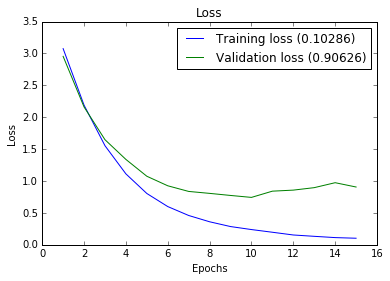

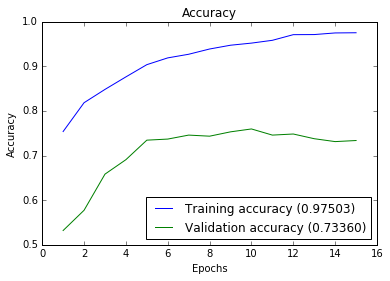

In [459]:
plot_history(history)
# check the network performance: overfitting
# regularization for GRU?
# LSTM?

In [460]:
best_rnn_model_with_glove_embeddings = load_model('./models/rnn_with_embeddings/weights-improvement-09-0.7595-200.hdf5')

y_pred_rnn_with_glove_embeddings = best_rnn_model_with_glove_embeddings.predict(
    padded_test_sequences, verbose=1, batch_size=2048)

y_pred_rnn_with_glove_embeddings = pd.DataFrame(y_pred_rnn_with_glove_embeddings, columns=['prediction'])
y_pred_rnn_with_glove_embeddings['prediction'] = y_pred_rnn_with_glove_embeddings['prediction'].map(lambda p: 
                                                                                                    1 if p >= 0.5 else 0)
y_pred_rnn_with_glove_embeddings.to_csv('./predictions/y_pred_rnn_with_glove_embeddings.csv', index=False)

1235/1235 [==============================] - 3s


In [461]:
y_pred_rnn_with_glove_embeddings = pd.read_csv('./predictions/y_pred_rnn_with_glove_embeddings.csv')
print(accuracy_score(ver_y, y_pred_rnn_with_glove_embeddings))

0.531983805668


In [462]:
tweets.extend(tweets2)
tweets.extend(tweets3)
tweets.extend(tweets4)
# the final data is streaming data without including DT.
tweets.extend(tweets5)
tweets.extend(tweets6)

text = [tweets[i]['text'] for i in range(150000)]
rep_to = [tweets[i]['in_reply_to_user_id'] for i in range(150000)]

In [464]:
cleantext = []
for tweet in text:
    cleantext.append(clean_tweets_glove(tweet))
text_sequences = tokenizer.texts_to_sequences(cleantext)
print((cleantext[10]))
print((text_sequences[10]))
padded_text_sequences = pad_sequences(text_sequences, maxlen=MAX_LENGTH)

 consider urself lucky cuz my love for you is endless and I have high standards for boys. Be grateful. <url> 
[1092, 1005, 930, 45, 91, 15, 2, 8, 5524, 5, 7, 19, 466, 3364, 15, 643, 20, 4372, 16]


In [465]:
best_rnn_model_with_glove_embeddings = load_model('./models/rnn_with_embeddings/weights-improvement-09-0.7595-200.hdf5')

y_pred_rnn_with_glove_embeddings = best_rnn_model_with_glove_embeddings.predict(
    padded_text_sequences, verbose=1, batch_size=2048)

y_pred_rnn_with_glove_embeddings = pd.DataFrame(y_pred_rnn_with_glove_embeddings, columns=['prediction'])
y_pred_rnn_with_glove_embeddings['prediction'] = y_pred_rnn_with_glove_embeddings['prediction'].map(lambda p: 
                                                                                                    1 if p >= 0.5 else 0)
y_pred_rnn_with_glove_embeddings.to_csv('./predictions/tweets_rnn_with_glove_embeddings.csv', index=False)

150000/150000 [==============================] - 216s   


In [466]:
y_pred_rnn_with_glove_embeddings['user_id'] = rep_to

In [467]:
data = y_pred_rnn_with_glove_embeddings

In [468]:
tweet_set = []
for tweet in text:
    tweet_set.append(bag_of_words(tweet))

In [469]:
lsvmdata = nbclassifier.classify_many(tweet_set)

In [470]:
lsvmdata = pd.DataFrame(lsvmdata,columns=['prediction'])
lsvmdata['user_id'] = rep_to

In [471]:
data.head(5)


,prediction,user_id
0,1,79293791
1,0,25073877
2,1,25073877
3,0,25073877
4,0,25073877


In [472]:
#lsvmdf=lsvmdata.groupby('user_id')['prediction'].apply(lambda x: (x=='ins').sum()).reset_index(name='ins_count')
df = data.groupby('user_id')['prediction'].apply(lambda x: (x==1).sum()).reset_index(name='ins_count')
#user_info = user_info.join(lsvmdf.set_index('user_id'),on='user_id')
#user_info = user_info.join(df.set_index('user_id'),on='user_id')
if 'ins_count' in user_info:
    del user_info['ins_count']
user_info = user_info.join(df.set_index('user_id'),on='user_id')


In [473]:
print(data.loc[data['prediction']==1])
print(cleantext[55])
print(text[55])

        prediction    user_id
0                1   79293791
2                1   25073877
7                1   25073877
36               1   25073877
39               1   25073877
45               1     428333
49               1   25073877
51               1   25073877
55               1   25073877
58               1   25073877
62               1   25073877
67               1     759251
69               1   44409004
76               1   25073877
88               1   25073877
95               1   25073877
97               1   25073877
102              1   25073877
104              1     759251
106              1   25073877
114              1   25073877
120              1   25073877
121              1    2557521
123              1   25073877
125              1   25073877
126              1   25073877
128              1   25073877
129              1   25073877
132              1   18839785
134              1   25073877
...            ...        ...
149852           1     759251
149862    

In [474]:
user_info['ins_count']

0      143
1      147
2      406
3       51
4      510
5      209
6       94
7      589
8      133
9       15
10     629
11     664
12     128
13    3054
14     290
15      31
16     271
17    9514
18     116
19      18
20      35
21     135
22     633
23      20
24      12
25     776
26     166
27      30
28    1987
29     404
30     120
31      64
32     122
33      84
34     213
35     220
36      18
37     141
38      37
39     262
40      27
41     304
42     171
43      10
44      49
45     980
46      27
47      26
48    1237
49       8
Name: ins_count, dtype: int64

In [477]:
#cnt = lsvmdata.user_name.value_counts().reset_index().rename(columns={'index':'user_name','user_name':'count'})
cnt = data.user_id.value_counts().reset_index().rename(columns={'index':'user_id','user_id':'count'})

cnt.head(5)
if 'count' in user_info:
    del user_info['count']
user_info = user_info.join(cnt.set_index('user_id'),on='user_id')
user_info['norm_act'] = user_info['actlevel']*0.5+1
user_info['reply_expect'] = user_info.norm_act.multiply(user_info['followers'])
user_info.head(5)
user_info = user_info.rename(index=str, columns={"Unnamed: 0": "follower_rank"})
# there's an obvious outlier in the actual replies one get vs. expected reply based on current epoch activity * # followers!
# we name the ratio of actual reply to the expected reply based on # of followers and user activity level as 'controversy'
user_info['controversy'] = user_info['count']/user_info['reply_expect']
user_info.loc[user_info['controversy']<700].describe()
# there is no user who got 0 replies! 
# excluding the outlier, the standard deviation reduces significantly
# 

,follower_rank,followers,user_id,actlevel,ins_count,norm_act,reply_expect,controversy,count
count,49.000000,49.000000,4.900000e+01,49.000000,49.000000,49.000000,49.000000,49.000000,49.000000
mean,24.653061,50.816327,5.992345e+07,0.029888,322.775510,1.014944,50.798003,35.865071,1802.040816
std,14.687794,21.142053,6.527732e+07,0.820958,542.718783,0.410479,28.145259,46.039826,2750.442805
min,0.000000,30.000000,4.283330e+05,-0.996127,8.000000,0.501937,16.420184,1.291783,28.000000
25%,12.000000,35.000000,1.640968e+07,-0.829082,35.000000,0.585459,27.576759,8.154133,267.000000
50%,25.000000,42.000000,2.656595e+07,0.464652,135.000000,1.232326,47.062306,18.572472,792.000000
75%,37.000000,58.000000,1.002209e+08,0.820686,304.000000,1.410343,60.644750,36.504851,2023.000000
max,49.000000,110.000000,2.684145e+08,0.999605,3054.000000,1.499803,135.256400,226.537211,13460.000000


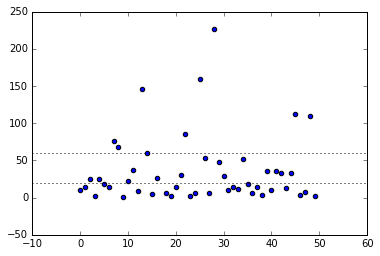

In [478]:
#plt.scatter(user_info['follower_rank'],user_info['controversy'])
plt.scatter(user_info['follower_rank'].loc[user_info['controversy']<700],user_info['controversy'].loc[user_info['controversy']<700])
plt.axhline(y=20,linestyle=':',color='black')
plt.axhline(y=60,linestyle=':',color='black')

In [479]:
# create a categorical controversy data
user_info.loc[user_info['controversy']<=20,'controversy_cat'] = 'low' #4
user_info.loc[(user_info['controversy']<=60) & (user_info['controversy']>20),'controversy_cat'] = 'med' #11
user_info.loc[user_info['controversy']>60,'controversy_cat'] = 'high' #34
# define insult fraction : 
user_info['ins_frac'] = user_info['ins_count']/user_info['count']/0.5
user_info.head(10)

,follower_rank,activity,country,followers,user_id,user_name,gender,actlevel,job,ins_count,norm_act,reply_expect,controversy,count,controversy_cat,ins_frac
0,0,Musician,USA,110,21447363,katyperry,F,-0.995836,artist,143,0.502082,55.229000,10.809539,597,low,0.479062
1,1,Musician,CAN,107,27260086,justinbieber,M,-0.534914,artist,147,0.732543,78.382113,13.714864,1075,low,0.273488
2,2,Former U.S. President,USA,103,813286,BarackObama,M,0.626338,politician,406,1.313169,135.256400,24.420286,3303,med,0.245837
3,3,Musician,BAR,89,79293791,rihanna,F,0.977174,artist,51,1.488587,132.484223,2.136103,283,low,0.360424
4,4,Musician,USA,86,17919972,taylorswift13,F,-0.647692,artist,510,0.676154,58.149255,25.296971,1471,med,0.693406
5,5,Musician,USA,79,14230524,ladygaga,F,-0.829082,artist,209,0.585459,46.251248,18.572472,859,low,0.486612
6,6,Comedian,USA,78,15846407,TheEllenShow,F,-0.613096,artist,94,0.693452,54.089252,13.699579,741,low,0.253711
7,7,Footballer,POR,74,155659213,Cristiano,M,-0.875348,sports,589,0.562326,41.612125,76.396003,3179,high,0.370557
8,8,Online video platform,USA,72,10228272,YouTube,G,-0.961781,platform,133,0.519109,37.375883,68.466609,2559,high,0.103947
9,9,Musician and actor,USA,66,26565946,jtimberlake,M,0.955745,artist,15,1.477873,97.539597,1.291783,126,low,0.238095


In [480]:
if 'followers' not in lsvmdata:
    lsvmdata = lsvmdata.join(user_info.set_index('user_id'),on='user_id')
if 'followers' not in data:
    data = data.join(user_info.set_index('user_id'),on='user_id')
data.head(5)

,prediction,user_id,follower_rank,activity,country,followers,user_name,gender,actlevel,job,ins_count,norm_act,reply_expect,controversy,count,controversy_cat,ins_frac
0,1,79293791,3,Musician,BAR,89,rihanna,F,0.977174,artist,51,1.488587,132.484223,2.136103,283,low,0.360424
1,0,25073877,17,Current U.S. President,USA,53,realDonaldTrump,M,0.898355,politician,9514,1.449178,76.806420,803.318265,61700,high,0.308395
2,1,25073877,17,Current U.S. President,USA,53,realDonaldTrump,M,0.898355,politician,9514,1.449178,76.806420,803.318265,61700,high,0.308395
3,0,25073877,17,Current U.S. President,USA,53,realDonaldTrump,M,0.898355,politician,9514,1.449178,76.806420,803.318265,61700,high,0.308395
4,0,25073877,17,Current U.S. President,USA,53,realDonaldTrump,M,0.898355,politician,9514,1.449178,76.806420,803.318265,61700,high,0.308395


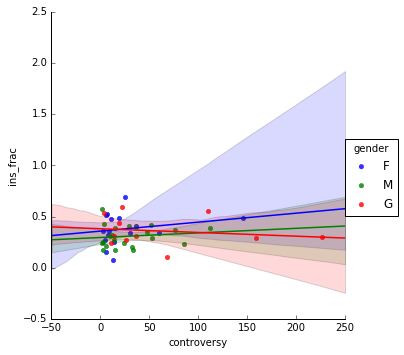

In [481]:
# tmp is the user_info with outlier removed
tmp = user_info.loc[user_info['controversy']<700]
sns.lmplot(x='controversy',y='ins_frac',hue='gender', data=tmp)

# Interpretation
For personal accounts (female and male both), there is a small trend in recieving more insult as the controversy level goes up (positive slope of the graphs), however there is large uncertainty due to limited number of accounts studied (50) and also small insult fraction (in most cases less than 10 %). Also as controversy for most accounts stays between [0,100], datapoints with higher controversy, which is relatively fewer in number, tend to dominate the slope.<br>
Female accounts seem to receive more insult than male account in general regardless of the controversy, and the more controversial the account is, the more likely a female account is to be insulted. The slope is the steepest for female account amoun three groups.

# Playing aroud the data

In [482]:
# data includes sentiment analysis result from NN
#data = data.rename(index=str, columns={"Unnamed: 0": "follower_rank"})
# lsvmdata includes sentiment analysis result from linear svm
#lsvmdata = lsvmdata.rename(index=str, columns={"Unnamed: 0": "follower_rank"})

In [483]:
data['activity'].unique()

array(['Musician', 'Current U.S. President', 'News channel', 'Newspaper',
       'Actor and producer', 'Social media platform', 'Sports channel',
       'Current Prime Minister of India', 'Online video platform',
       'Footballer', 'Actor', 'Musician and actress', 'Comedian', 'Rapper',
       'Football club', 'Former U.S. President', 'Basketball player',
       'Sports news', 'Television personality', 'Musician and actor',
       'Comedian and actor', 'Television personality and businesswoman',
       'Businessman and philanthropist', 'Band'], dtype=object)

# Categorizing activity into jobs
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('Musician' or 'Rapper' or 'Band') in x), 'job'] = 'artist'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('Comedian' or 'Actor') in x), 'job'] = 'artist'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('President' or 'Minister') in x), 'job'] = 'politician'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('usiness' in x)), 'job'] = 'business'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('platform' in x)), 'job'] = 'platform'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('channel') in x), 'job'] = 'channel'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('ball') in x), 'job'] = 'sports'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('ews') in x), 'job'] = 'news'
lsvmdata.loc[lsvmdata.activity.apply(lambda x: ('elevision') in x), 'job'] = 'TV'

In [484]:
user_info.loc[(user_info['gender']=='F')&(user_info['job']=='artist')].describe()

,follower_rank,followers,user_id,actlevel,ins_count,norm_act,reply_expect,controversy,count,ins_frac
count,14.000000,14.000000,1.400000e+01,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000,14.000000
mean,16.285714,62.428571,5.045506e+07,-0.296229,344.785714,0.851885,53.619379,25.219833,1506.142857,0.392870
std,14.301310,22.980642,6.664292e+07,0.802422,790.963597,0.401211,32.098677,37.829557,3252.453414,0.150675
min,0.000000,31.000000,1.423052e+07,-0.996127,10.000000,0.501937,19.744589,2.136103,117.000000,0.074906
25%,5.250000,46.750000,1.871795e+07,-0.827912,36.000000,0.586044,26.990837,6.890532,271.000000,0.326294
50%,13.500000,57.500000,2.604086e+07,-0.686924,122.000000,0.656538,50.509132,11.782277,655.000000,0.359735
75%,20.250000,78.750000,4.208041e+07,0.369119,192.500000,1.184559,65.431292,23.615846,844.750000,0.485338
max,47.000000,110.000000,2.684145e+08,0.999544,3054.000000,1.499772,132.484223,145.826787,12685.000000,0.693406


In [485]:
user_info.loc[(user_info['gender']=='M') & (user_info['controversy']<500)&(user_info['job']=='artist')].describe()

,follower_rank,followers,user_id,actlevel,ins_count,norm_act,reply_expect,controversy,count,ins_frac
count,15.000000,15.000000,1.500000e+01,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,31.400000,43.466667,8.431085e+07,0.233889,175.200000,1.116944,48.073197,25.388523,1033.533333,0.299998
std,13.048262,19.697232,5.692708e+07,0.755606,251.358367,0.377803,23.122724,29.423534,1291.551054,0.090201
min,1.000000,33.000000,1.548544e+07,-0.972609,15.000000,0.513696,17.310294,1.291783,126.000000,0.171930
25%,26.000000,34.000000,2.688053e+07,-0.462483,23.500000,0.768758,35.036586,5.102486,176.000000,0.223094
50%,36.000000,35.000000,1.002209e+08,0.532642,84.000000,1.266321,47.062306,13.714864,570.000000,0.305085
75%,40.500000,41.500000,1.243741e+08,0.803605,192.000000,1.401802,55.819018,34.591077,1297.000000,0.388817
max,45.000000,107.000000,1.815617e+08,0.999605,980.000000,1.499803,97.539597,112.428847,5029.000000,0.422857


# Summary
i) there are 14 female and 9 male artists in this data<br>
ii) female artists have more followers <br>
iii) expected reply level is similar for both gendes, with larger scatter for females<br>
iv) mean and meadian controversy of male artists are more than double of that of female artists<br>
v) scatter in controversy is larger for male artists than female<br>
vi) male users tend to be more active on Twitter<br>


## Visualization
we have defined target activity via measures such as:

i) actlevel (norm_act) : activity model based on number of tweets published per most recent cycle (see section), and renormalization of it<br>
ii) reply_expect : actlevel * # of followers<br>
iii) controversy : actual reply count / reply_expect

while insult level is independently measured from the replies as it only relies on the sentiment from the text.
We use these quantities and see if there's any trend in data.

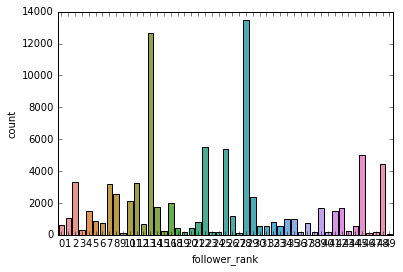

In [486]:
tmpdata = data.loc[data['follower_rank']!=17]
sns.countplot(tmpdata['follower_rank'])
# an obvious outlier is shown....

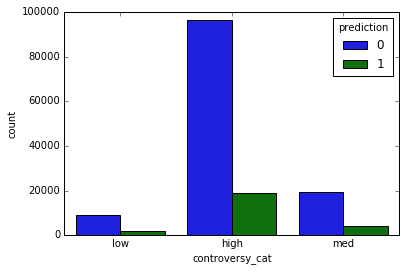

In [487]:
sns.countplot(x="controversy_cat",hue="prediction", data=data);
# in controversy_cat order, high-low-med, insult_fraction decreases (i.e. not a simple function of controversy)

In [488]:
tmpdata.loc[(tmpdata['controversy_cat']=='low')].describe() # ins_frac=(0.340,0.111)

,prediction,user_id,follower_rank,followers,actlevel,ins_count,norm_act,reply_expect,controversy,count,ins_frac
count,10790.000000,1.079000e+04,10790.000000,10790.000000,10790.000000,10790.000000,10790.000000,10790.000000,10790.000000,10790.000000,10790.000000
mean,0.169880,4.775137e+07,20.500649,58.684337,0.102656,112.034013,1.051328,56.121776,11.868955,636.408897,0.339759
std,0.375544,5.498768e+07,14.761751,26.581080,0.788406,64.552290,0.394203,21.856840,4.841126,296.101568,0.110928
min,0.000000,5.402612e+06,0.000000,30.000000,-0.995836,8.000000,0.502082,16.420184,1.291783,28.000000,0.074906
25%,0.000000,1.640968e+07,5.000000,36.000000,-0.726156,51.000000,0.636922,46.929012,8.260497,409.000000,0.253711
50%,0.000000,2.625717e+07,20.000000,46.000000,0.543908,122.000000,1.271954,53.232799,13.699579,713.000000,0.314607
75%,0.000000,4.440900e+07,35.000000,79.000000,0.957378,147.000000,1.478689,67.858637,14.831330,859.000000,0.437376
max,1.000000,2.684145e+08,49.000000,110.000000,0.998366,220.000000,1.499183,132.484223,18.898123,1075.000000,0.571429


In [489]:
tmpdata.loc[(tmpdata['controversy_cat']=='med')].describe() # ins_frac=(0.365,0.134)

,prediction,user_id,follower_rank,followers,actlevel,ins_count,norm_act,reply_expect,controversy,count,ins_frac
count,23556.000000,2.355600e+04,23556.000000,23556.000000,23556.000000,23556.000000,23556.000000,23556.000000,23556.000000,23556.000000,23556.000000
mean,0.182714,4.622756e+07,20.937468,56.510104,0.382713,377.669002,1.191357,68.465874,33.744568,2101.674817,0.365427
std,0.386440,5.156744e+07,14.341498,23.424515,0.715178,182.420950,0.357589,35.859669,9.342548,857.277733,0.134587
min,0.000000,4.283330e+05,2.000000,33.000000,-0.981678,49.000000,0.509161,17.310294,22.377053,570.000000,0.171930
25%,0.000000,8.132860e+05,10.000000,36.000000,0.464652,262.000000,1.232326,47.370905,25.296971,1519.000000,0.267919
50%,0.000000,2.308340e+07,16.000000,55.000000,0.626338,404.000000,1.313169,58.149255,32.514084,2023.000000,0.344123
75%,0.000000,1.013114e+08,34.000000,63.000000,0.984078,510.000000,1.492039,89.522348,36.504851,3268.000000,0.406365
max,1.000000,1.584873e+08,44.000000,103.000000,0.999605,664.000000,1.499803,135.256400,52.711101,3303.000000,0.693406


In [490]:
tmpdata.loc[(tmpdata['controversy_cat']=='high')].describe() # ins_frac=(0.359,0.115)

,prediction,user_id,follower_rank,followers,actlevel,ins_count,norm_act,reply_expect,controversy,count,ins_frac
count,53954.000000,5.395400e+04,53954.000000,53954.000000,53954.000000,53954.000000,53954.000000,53954.000000,53954.000000,53954.000000,53954.000000
mean,0.179394,3.878477e+07,24.162954,47.656411,0.508177,1599.069430,1.254088,57.823164,144.555913,8634.451755,0.358787
std,0.383685,5.787788e+07,12.404891,12.501473,0.700291,980.396289,0.350146,19.118214,54.954191,4406.437596,0.114571
min,0.000000,7.592510e+05,7.000000,31.000000,-0.996127,133.000000,0.501937,28.610390,60.292781,1725.000000,0.103947
25%,0.000000,8.070950e+05,13.000000,41.000000,0.609948,776.000000,1.304974,40.454188,109.951534,5029.000000,0.295245
50%,0.000000,1.883978e+07,25.000000,42.000000,0.898355,1237.000000,1.449178,59.416287,145.826787,5502.000000,0.336232
75%,0.000000,3.450748e+07,28.000000,58.000000,0.984078,1987.000000,1.492039,64.157683,158.745186,12685.000000,0.481514
max,1.000000,1.815617e+08,48.000000,74.000000,0.999544,3054.000000,1.499772,86.986762,226.537211,13460.000000,0.556205


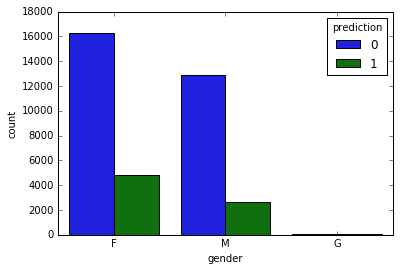

In [491]:
# remove outlier and plot #
sns.countplot(x="gender",hue="prediction", data=data.loc[(data['user_name']!='realDonaldTrump')&(data['job']=='artist')])

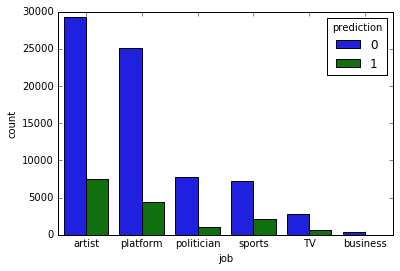

In [492]:
#sns.countplot(x="job",hue="prediction", data=lsvmdata.loc[lsvmdata['user_name']=='CNN'])
sns.countplot(x="job",hue="prediction", data=data.loc[data['user_name']!='realDonaldTrump'])

/home/ijee/anaconda3/lib/python3.5/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


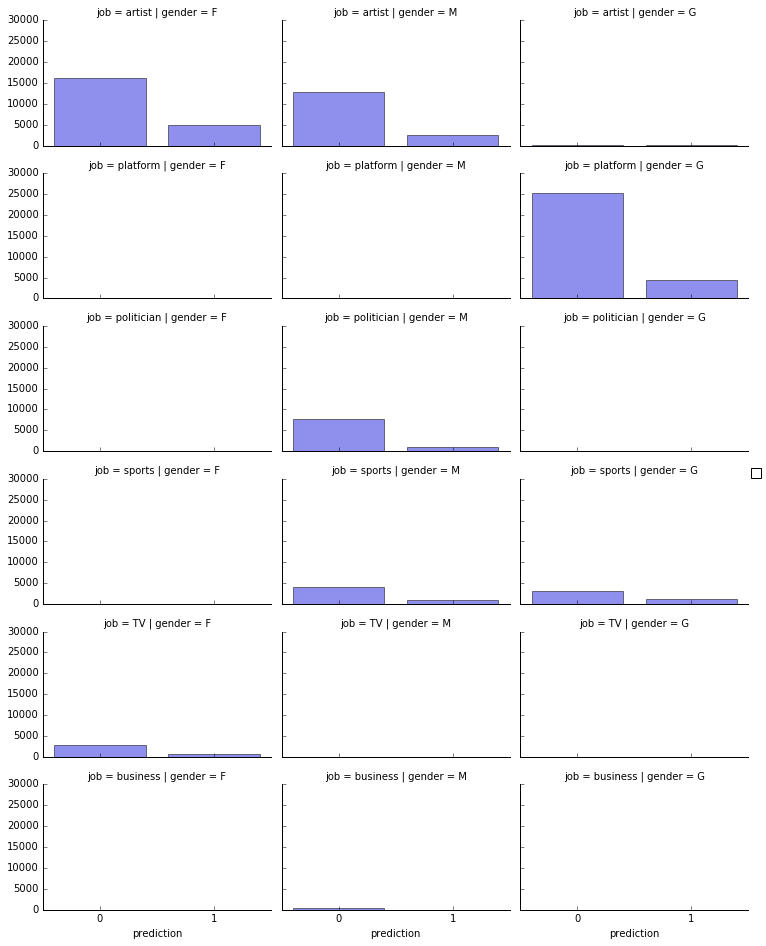

In [493]:
# removing outlier (getting WAY TOO MANY replies than other users)
grid = sns.FacetGrid(data.loc[data['user_name']!='realDonaldTrump'], col='gender', row='job', size=2.2, aspect=1.6)
grid.map(sns.countplot, 'prediction', alpha=.5)
grid.add_legend();
# among artists, where they have recieved similar amount of replies, the amount of insult female recieve is higher than that toward males

# Conclusions
We have performed sentiment analysis on collected Twitter replies to 50 most followed people, to see if there is a bias in the degree of insult people perceive depending on their background. Looking at collection of insulting comments were not particularly a pleasing experience, but as a result a few interesting results were found:
## Gender bias in occupation:
Note that all female figures has job that can be categorized either in "artist" or "TV personality", while fields e.g. "business" or "politician", "sports" are all males in the top 50 list. This makes the analysis harder, as we would like to remove as much difference as possible and compare an apple to another apple. In the end the only job category we could use for the main analysis was 'artist'.
## Insult bias
Using linear SVM classification for sentiment analysis, we found that female artist figures on Twitter recieves more insulting comments than male on average (We wanted to compare insult fraction among users with the same occupation category, however due to gender bias in occupation, we can only do so among artists).
## controversy - insult correlation?
The data exhibit a small correlation in controversy-insult correlation for both female and male accounts. No such trend is observed for group accounts. 

## Limitations
Since the number of accounts analyzed here are only 50, we cannot defend the statistical significance of our result.<br>
We collected tweets using Streaming API for random time windows, which may bias replies to users in specific time zones. We may be able to model this by analysing tweet distribution at one timezone and take into account this during the streaming window ws open, but we decided that this is out of the scope of current work.<br>
The type of sentiment analysis training data we perform is strictly speaking not a perfect match to the Twitter, as they are plain text. They are replies on a forum, which would at least guarantee similar length of text as tweets (won't be extensive in length), and it provides a large labeled dataset for insult classification, which is why we decided to reply on it to train the algorithm. The Twitter data from Mean Birds paper were inappropriate for our analysis, as their focus was more on finding the individual users who are aggressive / bullying or spamming. Furthermore, many of the problematic accounts / tweets were suspended or deleted, so it was hard to collect the text data from the list. Also, many of the accounts they categorized as aggressive were highly topic-related: such as Men's Right Activist etc, which, by text alone, does not show high degree of insult / aggression. <br>
